In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing libraries for data manipulation, model training, and evaluation
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # Import Random Forest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Mapping Dictionaries
sentiment_mapping = {0: 'Negative', 1: 'Positive', 2: 'Neutral'}
candidate_mapping = {0: 'BIDEN', 1: 'TRUMP'}

In [ ]:
# Function to load dataset
def load_dataset(file_path, chunksize=1000):
    return pd.read_csv(file_path, chunksize=chunksize)

In [ ]:
# Function for preprocessing and vectorizing data
def preprocess_and_vectorize_chunks(file_path, max_features=5000, chunksize=1000):
    chunk_list = []
    sentiment_map = {'positive': 1, 'negative': 0, 'neutral': 2}

    for chunk in load_dataset(file_path, chunksize=chunksize):
        chunk = chunk[['preprocessed_tweet', 'Candidate', 'sentiment']]
        chunk.dropna(subset=['preprocessed_tweet', 'Candidate', 'sentiment'], inplace=True)
        chunk = chunk[chunk['sentiment'].isin(sentiment_map.keys())]
        chunk['sentiment'] = chunk['sentiment'].map(sentiment_map)
        chunk['Candidate'] = chunk['Candidate'].apply(lambda x: 1 if x == 'TRUMP' else 0)
        chunk_list.append(chunk)

    df = pd.concat(chunk_list, axis=0)

    tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
    X = tfidf_vectorizer.fit_transform(df['preprocessed_tweet'])
    y = df['sentiment'].values
    candidate = df['Candidate'].values

    return X, y, candidate, tfidf_vectorizer, df

In [ ]:
# Train-validation-test split
def train_validation_test_split(X, y, candidate, test_size=0.1, val_size=0.1, random_state=42):
    X_train_val, X_test, y_train_val, y_test, candidate_train_val, candidate_test = train_test_split(
        X, y, candidate, test_size=test_size, random_state=random_state)

    val_adjusted_size = val_size / (1 - test_size)

    X_train, X_val, y_train, y_val, candidate_train, candidate_val = train_test_split(
        X_train_val, y_train_val, candidate_train_val, test_size=val_adjusted_size, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test, candidate_train, candidate_val, candidate_test

In [ ]:
# Function to train Random Forest Classifier
def train_random_forest(X_train, y_train, n_estimators=100, max_depth=None, random_state=42):
    print("Training Random Forest Classifier...\n")
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    model.fit(X_train, y_train, sample_weight=sample_weights)
    return model

In [ ]:
# Function for mapping labels
def map_labels(df, candidate_col='Candidate', sentiment_col='Predicted Sentiment'):
    df[candidate_col] = df[candidate_col].map(candidate_mapping)
    df[sentiment_col] = df[sentiment_col].map(sentiment_mapping)
    return df

In [ ]:
# Display original sentiment counts
def display_original_sentiment_counts(trump_biden_df):
    original_df = map_labels(trump_biden_df.copy(), candidate_col='Candidate', sentiment_col='sentiment')
    sentiment_counts = original_df.groupby(['Candidate', 'sentiment']).size().unstack(fill_value=0)
    print("Original Sentiment Counts:")
    print(sentiment_counts)
    plot_individual_sentiments(sentiment_counts, 'Sentiment Distribution Per Candidate')

In [ ]:
def display_sentiment_counts(trump_biden_df, title):
    trump_biden_df = map_labels(trump_biden_df.copy(), candidate_col='Candidate', sentiment_col='Predicted Sentiment')
    sentiment_counts = trump_biden_df.groupby(['Candidate', 'Predicted Sentiment']).size().unstack(fill_value=0)
    print(f"{title}:\n", sentiment_counts)
    plot_individual_sentiments(sentiment_counts, title, adjusted=True)

In [ ]:
# Plot sentiment counts
def plot_individual_sentiments(sentiment_counts, title, adjusted=False):
    candidates = ['BIDEN', 'TRUMP']
    index = np.arange(len(candidates))

    negative = sentiment_counts.get('Negative', np.zeros(len(candidates)))
    neutral = sentiment_counts.get('Neutral', np.zeros(len(candidates)))
    positive = sentiment_counts.get('Positive', np.zeros(len(candidates)))

    bar_width = 0.25

    plt.figure(figsize=(10, 6))
    plt.bar(index, negative, bar_width, label='Negative', color='navy')
    if not adjusted:
        plt.bar(index + bar_width, neutral, bar_width, label='Neutral', color='gray')
    plt.bar(index + (2 * bar_width if not adjusted else bar_width), positive, bar_width, label='Positive', color='gold')

    plt.xlabel('Candidate')
    plt.ylabel('Number of Tweets')
    plt.title(title)
    plt.xticks(index + bar_width, candidates)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Function for distributing neutral sentiments
def distribute_neutral_sentiments(y_pred_labels, candidate_labels):
    redistributed_predictions = np.copy(y_pred_labels)

    for candidate in np.unique(candidate_labels):
        candidate_mask = (candidate_labels == candidate)
        candidate_predicted_labels = y_pred_labels[candidate_mask]

        positive_count = np.sum(candidate_predicted_labels == 1)
        negative_count = np.sum(candidate_predicted_labels == 0)
        neutral_count = np.sum(candidate_predicted_labels == 2)

        total_decided = positive_count + negative_count

        if total_decided > 0 and neutral_count > 0:
            positive_share = positive_count / total_decided
            negative_share = negative_count / total_decided

            allocated_positive = int(neutral_count * positive_share)
            allocated_negative = neutral_count - allocated_positive

            neutral_indices = np.where((candidate_labels == candidate) & (y_pred_labels == 2))[0]

            redistributed_predictions[neutral_indices[:allocated_positive]] = 1
            redistributed_predictions[neutral_indices[allocated_positive:]] = 0

    return redistributed_predictions

In [ ]:
# Function for calculating adjusted sentiment share
def calculate_adjusted_sentiment_share(adjusted_df, candidate_val):
    positive_count = np.sum((adjusted_df['Candidate'] == candidate_val) & (adjusted_df['Predicted Sentiment'] == 1))
    total_count = np.sum(adjusted_df['Candidate'] == candidate_val)

    positive_share = positive_count / total_count if total_count > 0 else 0
    return positive_share

In [ ]:
# Evaluate the model and plot metrics
def evaluate_model(model, X_test, y_test, model_name, metrics_dir):
    os.makedirs(metrics_dir, exist_ok=True)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)

    # Define target names for classification report and confusion matrix
    target_names = ['Negative', 'Positive', 'Neutral']

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

    print(f'{model_name} Accuracy: {accuracy}')
    print(f'F1-Score: {f1}')
    print(f'ROC AUC Score: {roc_auc}')

    # Save the metrics to a CSV file in metrics_dir
    results_df = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'F1-Score': [f1],
        'ROC AUC Score': [roc_auc]
    })
    metrics_file = os.path.join(metrics_dir, f'{model_name}_metrics.csv')
    if not os.path.isfile(metrics_file):
        results_df.to_csv(metrics_file, index=False, mode='w')
    else:
        results_df.to_csv(metrics_file, index=False, mode='a', header=False)

    # Print the classification report and confusion matrix
    report = classification_report(y_test, y_pred, target_names=target_names)
    print(report)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    # Compute ROC curves and AUC
    fpr, tpr, roc_auc = {}, {}, {}
    colors = ['gold', 'navy', 'grey']
    for i, label in enumerate(target_names):
        fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_prob[:, i])
        roc_auc[i] = roc_auc_score((y_test == i).astype(int), y_pred_prob[:, i])

    # Plot ROC curves with specified colors
    plt.figure(figsize=(10, 8))
    for i, (label, color) in enumerate(zip(target_names, colors)):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{label} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve by Class')
    plt.legend(loc="lower right")
    plt.show()

    # Plot overall ROC curve (macro-average)
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(target_names))]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(len(target_names)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= len(target_names)
    overall_auc = np.trapz(mean_tpr, all_fpr)

    plt.figure(figsize=(6, 6))
    plt.step(all_fpr, mean_tpr, color='blue', lw=2, where='post', label=f'Macro-average (area = {overall_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Overall ROC Curve (Macro-average)', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()

    # Save overall ROC curve data to CSV in metrics_dir
    roc_curve_file = os.path.join(metrics_dir, f'{model_name}_roc_curve.csv')
    roc_data = pd.DataFrame({'fpr': all_fpr, 'tpr': mean_tpr})
    roc_data.to_csv(roc_curve_file, index=False)
    print(f"ROC data saved to {roc_curve_file}")

    return accuracy, y_pred

In [ ]:
def extract_polling_shares(polling_data):
    """
    Extracts raw polling shares for Trump, Biden, and Others,
    and normalizes them to ensure the total is 100%.
    """
    # Extract raw polling percentages
    trump_polling = polling_data[polling_data['candidate_name'] == 'Donald Trump']['pct'].mean()
    biden_polling = polling_data[polling_data['candidate_name'] == 'Joe Biden']['pct'].mean()
    others_polling = polling_data[polling_data['candidate_name'] == 'Other Candidates']['pct'].mean()

    # Handle missing values
    trump_polling = trump_polling if not np.isnan(trump_polling) else 0
    biden_polling = biden_polling if not np.isnan(biden_polling) else 0
    others_polling = others_polling if not np.isnan(others_polling) else 0

    # Sum of all raw percentages
    total_polling = trump_polling + biden_polling + others_polling

    # Normalize percentages to ensure total is 100%
    normalized_trump = (trump_polling / total_polling) * 100 if total_polling > 0 else 0
    normalized_biden = (biden_polling / total_polling) * 100 if total_polling > 0 else 0
    normalized_others = (others_polling / total_polling) * 100 if total_polling > 0 else 0

    # Print normalized polling percentages
    print("Raw Polling Percentages (Normalized):")
    print(f"Donald Trump: {normalized_trump:.2f}%, Joe Biden: {normalized_biden:.2f}%, Others: {normalized_others:.2f}%")

    return normalized_trump, normalized_biden, normalized_others

In [ ]:
def predict_election(positive_share_trump, positive_share_biden, polling_data, actual_others= 2.0, model_name=None, metrics_dir=None, beta=0.8):
    """
    Predicts election outcome with the assumption that 'Others' receive less than 2% of the total vote.
    Excess 'Others' share is redistributed proportionally to Trump and Biden.

    Parameters:
    - positive_share_trump: Sentiment share for Trump.
    - positive_share_biden: Sentiment share for Biden.
    - polling_data: Polling data containing raw percentages.
    - actual_others: Assumed actual vote share for 'Others' (default: 1.9%).
    - beta: Decay factor to reduce the impact of 'Others' in polling data.

    Returns:
    - Normalized percentages for Trump, Biden, and Others, and the predicted winner.
    """
        # Ensure metrics_dir exists
    os.makedirs(metrics_dir, exist_ok=True)

    # Extract raw polling percentages
    trump_polling = polling_data[polling_data['candidate_name'] == 'Donald Trump']['pct'].mean()
    biden_polling = polling_data[polling_data['candidate_name'] == 'Joe Biden']['pct'].mean()
    others_polling = polling_data[polling_data['candidate_name'] == 'Other Candidates']['pct'].mean()

    # Handle missing data (NaN)
    trump_polling = trump_polling if not np.isnan(trump_polling) else 0
    biden_polling = biden_polling if not np.isnan(biden_polling) else 0
    others_polling = others_polling if not np.isnan(others_polling) else 0

    # Apply decay factor to "Others" share
    adjusted_others_polling = others_polling * beta
    adjusted_others_polling = min(adjusted_others_polling, actual_others)  # Cap at assumed actual 'Others' share (e.g., 1.9%)

    # Redistribute excess "Others" proportionally to Trump and Biden
    excess_others = others_polling - adjusted_others_polling
    total_polling = trump_polling + biden_polling
    redistributed_trump = (excess_others * (trump_polling / total_polling)) if total_polling > 0 else 0
    redistributed_biden = (excess_others * (biden_polling / total_polling)) if total_polling > 0 else 0

    # Adjust Trump and Biden shares
    adjusted_trump = trump_polling + redistributed_trump
    adjusted_biden = biden_polling + redistributed_biden

    # Normalize polling shares to account for sentiment data
    polling_weight = 0.9
    sentiment_weight = 2
    final_trump_score = polling_weight * adjusted_trump + sentiment_weight * positive_share_trump
    final_biden_score = polling_weight * adjusted_biden + sentiment_weight * positive_share_biden

    # Normalize scores to sum to 100%
    total_votes = final_trump_score + final_biden_score + adjusted_others_polling
    normalized_trump = (final_trump_score / total_votes) * 100
    normalized_biden = (final_biden_score / total_votes) * 100
    normalized_others = (adjusted_others_polling / total_votes) * 100

    # Determine the winner
    winner = 'TRUMP' if normalized_trump > normalized_biden else 'BIDEN'

    # Print final results
    print(f"Trump Score: {normalized_trump:.2f}%, Biden Score: {normalized_biden:.2f}%, Others: {normalized_others:.2f}%")
    print(f"Predicted Winner: {winner}")

    return normalized_trump, normalized_biden, normalized_others, winner

In [ ]:
def plot_sentiment_vs_polling(trump_score, biden_score, winner):
    # Define candidates and their scores
    candidates = ['TRUMP', 'BIDEN', 'OTHERS']
    others_score = 100 - trump_score - biden_score
    scores = [trump_score, biden_score, others_score]
    colors = ['navy', 'gold', 'gray']

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.bar(candidates, scores, color=colors, edgecolor='black', alpha=0.8)

    # Add text labels above each bar
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
                 f"{score:.2f}%", ha='center', va='bottom', fontsize=12)

    # Customize the chart
    plt.ylabel('Score (%)', fontsize=14)
    plt.xlabel('Candidates', fontsize=14)
    plt.title(f'Predicted Election Outcome ({winner} Wins)', fontsize=16, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0, 100)  # Ensure y-axis is scaled from 0 to 100
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for y-axis

    # Show the plot
    plt.tight_layout()
    plt.show()

Original Sentiment Counts:
sentiment  Negative  Neutral  Positive
Candidate                             
BIDEN         78502    84573    152159
TRUMP        157293   116426    154887


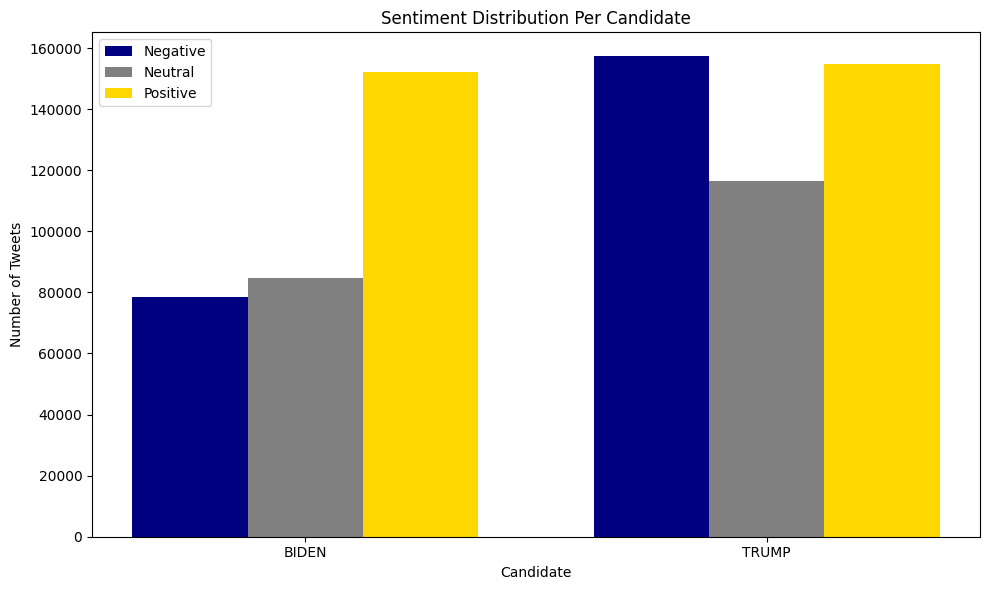

Training Random Forest Classifier...

Random Forest Classifier Accuracy: 0.8228382447838245
F1-Score: 0.8222221298543522
ROC AUC Score: 0.9353424282901543
              precision    recall  f1-score   support

    Negative       0.81      0.76      0.79     23677
    Positive       0.84      0.83      0.83     30703
     Neutral       0.81      0.89      0.85     20004

    accuracy                           0.82     74384
   macro avg       0.82      0.83      0.82     74384
weighted avg       0.82      0.82      0.82     74384



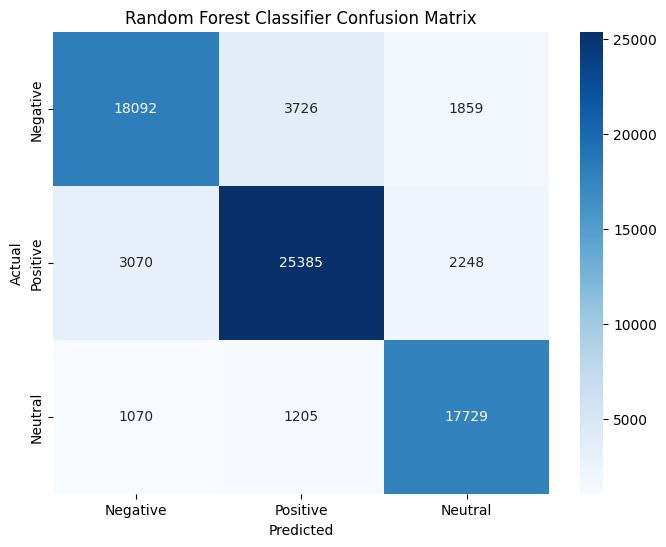

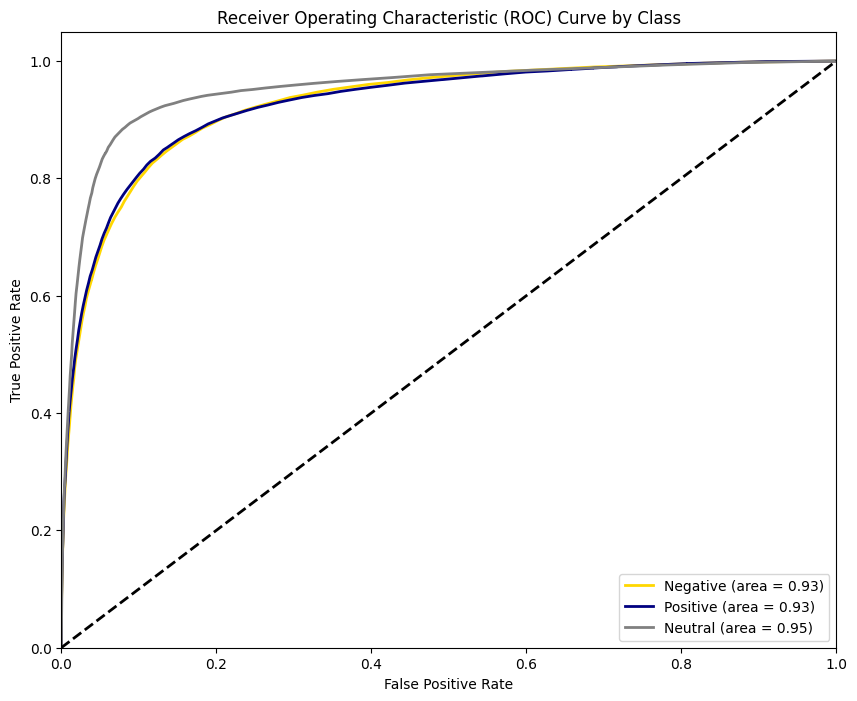

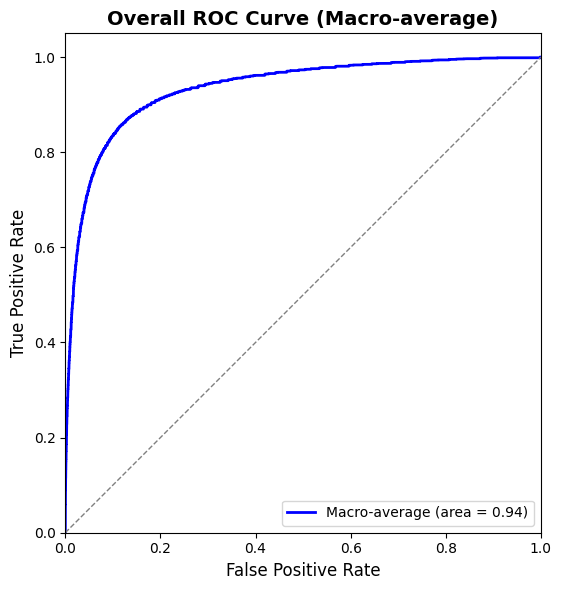

ROC data saved to /content/drive/MyDrive/models/histories/baseline_models/metrics/Random Forest Classifier_roc_curve.csv
Adjusted Positive Sentiment Shares: Trump: 0.50, Biden: 0.69
Adjusted Sentiment Distribution (Neutral Redistributed):
 Predicted Sentiment  Negative  Positive
Candidate                              
BIDEN                    9858     21689
TRUMP                   21514     21323


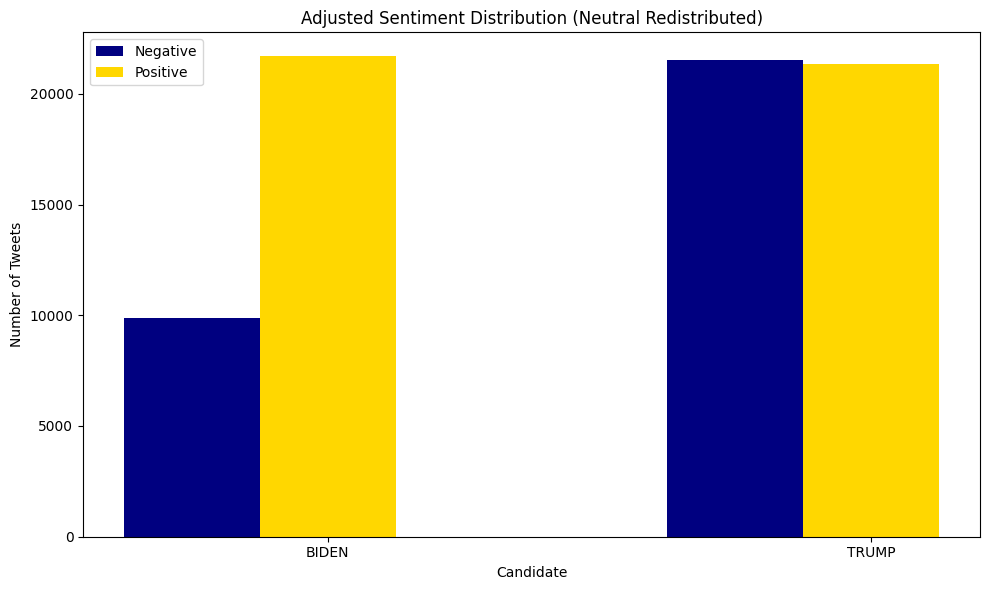

Positive Sentiment Shares: Trump: 0.36, Biden: 0.48
Biden - Positive: 15068, Negative: 6848, Neutral: 9631
Positive Sentiment Shares: Trump: 0.36, Biden: 0.48
Negative Sentiment Shares: Trump: 0.36, Biden: 0.22
Neutral Sentiment Shares: Trump: 0.28, Biden: 0.31
Trump Score: 46.22%, Biden Score: 51.97%, Others: 1.81%
Predicted Winner: BIDEN
Predicted Results:
Trump: 46.22%, Biden: 51.97%, Others: 1.81%


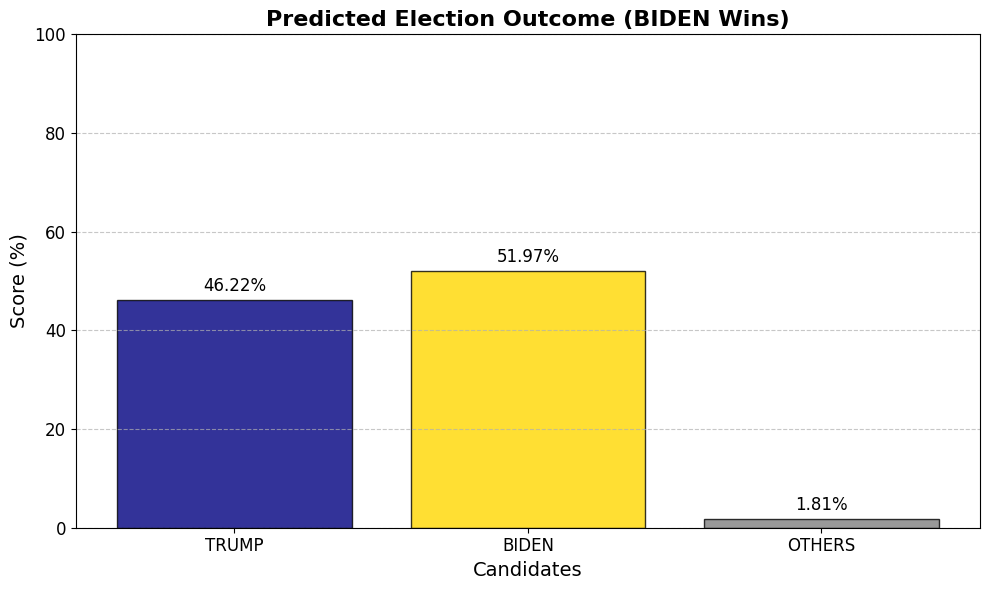

In [ ]:
# Main function
def main():
    file_path = '/content/drive/MyDrive/preprocessed_datasets/1_1_filtered_trump_biden_df.csv'
    polling_data_path = '/content/drive/MyDrive/preprocessed_datasets/preprocessed_poll_data.csv'
    polling_data = pd.read_csv(polling_data_path)

    # Define directory for metrics
    metrics_dir = '/content/drive/MyDrive/models/histories/baseline_models/metrics'
    os.makedirs(metrics_dir, exist_ok=True)

    max_features = 5000
    chunksize = 1000

    # Preprocess and Vectorize Data
    X, y, candidate, tfidf_vectorizer, trump_biden_df = preprocess_and_vectorize_chunks(file_path, max_features=max_features, chunksize=chunksize)

    # Display the Original Sentiment Counts
    display_original_sentiment_counts(trump_biden_df)

    # Train-validation-test split
    X_train, X_val, X_test, y_train, y_val, y_test, candidate_train, candidate_val, candidate_test = train_validation_test_split(X, y, candidate)

    # Train Random Forest Model
    rf_model = train_random_forest(X_train, y_train, n_estimators=100, max_depth=None, random_state=42)

    # Evaluate the Model and Save Results to CSV
    rf_accuracy, rf_y_pred = evaluate_model(rf_model, X_test, y_test, "Random Forest Classifier", metrics_dir=metrics_dir)

    # Redistribute Neutral Sentiments and Create DataFrame for Adjusted Predictions
    redistributed_predictions = distribute_neutral_sentiments(rf_y_pred, candidate_test)

    # Calculate sentiment shares using redistributed_predictions
    positive_share_trump = calculate_adjusted_sentiment_share(
        pd.DataFrame({'Candidate': candidate_test, 'Predicted Sentiment': redistributed_predictions}), 1
    )
    positive_share_biden = calculate_adjusted_sentiment_share(
        pd.DataFrame({'Candidate': candidate_test, 'Predicted Sentiment': redistributed_predictions}), 0
    )

    print(f"Adjusted Positive Sentiment Shares: Trump: {positive_share_trump:.2f}, Biden: {positive_share_biden:.2f}")
    test_df = pd.DataFrame({'Candidate': candidate_test, 'Predicted Sentiment': redistributed_predictions})

    # Display Adjusted Sentiment Counts
    display_sentiment_counts(test_df, 'Adjusted Sentiment Distribution (Neutral Redistributed)')


    # Calculate sentiment shares

    y_pred_labels = rf_y_pred  # usage of predicted labels

    trump_positive = sum((candidate_test == 1) & (y_pred_labels == 1))
    trump_negative = sum((candidate_test == 1) & (y_pred_labels == 0))
    trump_neutral = sum((candidate_test == 1) & (y_pred_labels == 2))

    biden_positive = sum((candidate_test == 0) & (y_pred_labels == 1))
    biden_negative = sum((candidate_test == 0) & (y_pred_labels == 0))
    biden_neutral = sum((candidate_test == 0) & (y_pred_labels == 2))

    positive_share_trump = trump_positive / sum(candidate_test == 1)
    positive_share_biden = biden_positive / sum(candidate_test == 0)

    print(f"Positive Sentiment Shares: Trump: {positive_share_trump:.2f}, Biden: {positive_share_biden:.2f}")
    print(f"Biden - Positive: {biden_positive}, Negative: {biden_negative}, Neutral: {biden_neutral}")

    # Calculate sentiment shares
    positive_share_trump = trump_positive / sum(candidate_test == 1)
    positive_share_biden = biden_positive / sum(candidate_test == 0)
    neutral_share_trump = trump_neutral / sum(candidate_test == 1)
    neutral_share_biden = biden_neutral / sum(candidate_test == 0)
    negative_share_trump = trump_negative / sum(candidate_test == 1)
    negative_share_biden = biden_negative / sum(candidate_test == 0)

    print(f"Positive Sentiment Shares: Trump: {positive_share_trump:.2f}, Biden: {positive_share_biden:.2f}")
    print(f"Negative Sentiment Shares: Trump: {negative_share_trump:.2f}, Biden: {negative_share_biden:.2f}")
    print(f"Neutral Sentiment Shares: Trump: {neutral_share_trump:.2f}, Biden: {neutral_share_biden:.2f}")


    # Calculate Adjusted Sentiment Shares for Election Prediction
    positive_share_trump_rf = calculate_adjusted_sentiment_share(test_df, 1)
    positive_share_biden_rf = calculate_adjusted_sentiment_share(test_df, 0)

    # Predict election outcome using decay factor (beta)
    trump_score, biden_score, others_score, predicted_winner = predict_election(
        positive_share_trump, positive_share_biden, polling_data, model_name="Random Forest Classifier", metrics_dir=metrics_dir, actual_others= 2.0, beta=0.8
    )


    print(f"Predicted Results:\nTrump: {trump_score:.2f}%, Biden: {biden_score:.2f}%, Others: {others_score:.2f}%")

    # Plot the predicted result
    plot_sentiment_vs_polling(trump_score, biden_score, predicted_winner)

if __name__ == "__main__":
    main()